In [1]:
import numpy as np
# import pycid
import networkx as nx
from matplotlib import pyplot as plt
import itertools
import time
import sys
import timeit
import random

I need methods for:
- sampling (enumerating?) from all possible cyclic graphs $G$ of size n
- sampling SCMs which fit $G$ (ideally including a mix of intrinsic and not)
- determining if an SCM $M$ is intrinsic
- constructing the graph $G$, given $M$ (unnecessary?)
- finding all d-separation statements from a cyclic graph $G$
- sampling a dataset from the observational distribution $P(V)$ of $M$
- checking whether an independence holds in the dataset from $P(V)$

Relevant resources:
- Constraint-based Causal Discovery for Non-Linear Structural Causal Models with Cycles and Latent Confounders, Mooji et. al.
- PYCID

@InProceedings{ james_fox-proc-scipy-2021,
  author    = { {J}ames {F}ox and {T}om {E}veritt and {R}yan {C}arey and {E}ric {L}anglois and {A}lessandro {A}bate and {M}ichael {W}ooldridge },
  title     = { {P}y{C}{I}{D}: {A} {P}ython {L}ibrary for {C}ausal {I}nfluence {D}iagrams },
  booktitle = { {P}roceedings of the 20th {P}ython in {S}cience {C}onference },
  pages     = { 43 - 51 },
  year      = { 2021 },
  editor    = { {M}eghann {A}garwal and {C}hris {C}alloway and {D}illon {N}iederhut and {D}avid {S}hupe },
  doi       = {10.25080/majora-1b6fd038-008}
}

In [2]:
def radius(A): # consistently fastest
    return np.max(np.abs(np.linalg.eigvals(A)))

def F(x,e,c=0.9):
    f0, f1 = e[:2]
    f2 = c*np.sin(x[0])*np.cos(x[3])+e[2]
    f3 = c*np.sin(x[1])*np.cos(x[2])+e[3]
    return np.vstack([f0,f1,f2,f3])

def find_stationary(e,x,length = 100,c=0.9):
    for t in range(length):
        x = F(x,e,c=c)
    return x

def find_stationary(e,c):
    y,x,z,w = e[0].copy(), e[1].copy(), e[2].copy(), e[3].copy()
    assert np.all(x*y<c), ( (x*y)[x*y>c][:2], (x)[x*y>c][:2], (y)[x*y>c][:2] )
    assert np.all(1-x*y>1-c)
    Z = (w*y+z)/(1-x*y)
    W = (z*x+w)/(1-x*y)
    return np.vstack([y, x,Z,W])

def generate_intrinsic(lower,upper,n,rnd=1,seconds=60):
    start = time.time()
    while time.time() - start < seconds:
        A = np.round(np.random.uniform(lower,upper,size=(n,n)),rnd)
        if radius(np.abs(A)) < 1:
            return A
    raise ValueError("allotted time exceeded")

In [3]:
def all_binary_matrices(n, m=None): # from stack exchange
    if m is None:
        m = n
    for i in range(2**(n*m)): 
        yield np.array([int(k) for k in "{0:b}".format(i).zfill(n*m)]).reshape(n,m)

def isomorphic(A,collection):
    GA = nx.DiGraph(A)
    for B in collection:
        GB = nx.DiGraph(B)
        if nx.algorithms.is_isomorphic(GA,GB):
            return True
    return False
        
def nice_graphs_naive(n): # able to get up to n=4
    """Returns all cyclic matrices of size n, 
    corresponding to graphs which have:
    - no unobserved confounding
    - strictly cyclic (no acylic graphs are returned)
    - strongly connected (encompasses previous condition)
    - no self loops
    - no isomorphic repeats
    """
    collection = []
    for A in all_binary_matrices(n):
        # throw out any that don't meet the conditions we care about
        if np.sum(A) < n: # clearly acyclic
            continue
        if np.any(np.diag(A)): # has self-loops
            continue
        # check if A is irreducible
        DG = nx.DiGraph(A)
        if nx.algorithms.components.is_strongly_connected(DG):
            if not isomorphic(A,collection):
                collection.append(A)
    return collection
    
def unit_nice_graphs():
    "unit test for nice_graphs_naive(n)"
    pass

In [4]:
for n in range(2,5):
    count = 0
    for A in nice_graphs_naive(n):
        count += 1
    print("n={}, count={}".format(n,count))

n=2, count=1
n=3, count=5
n=4, count=83


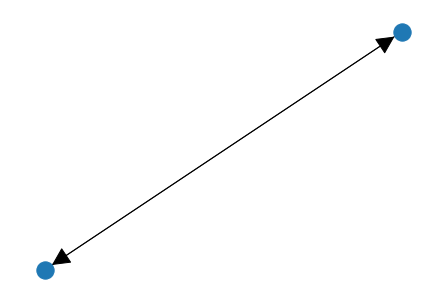

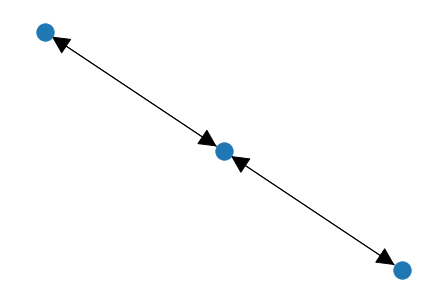

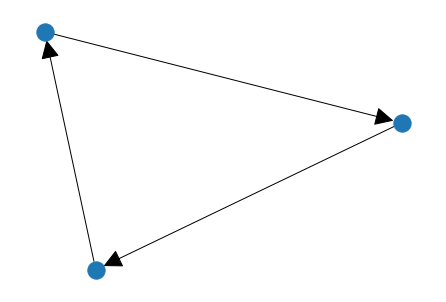

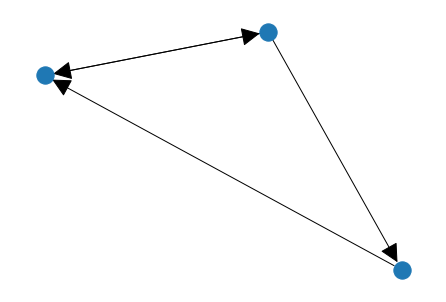

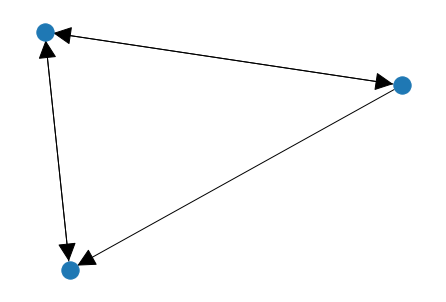

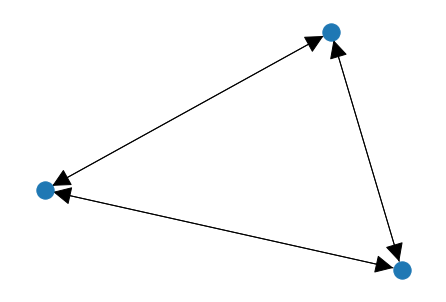

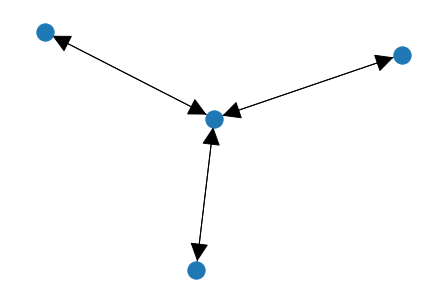

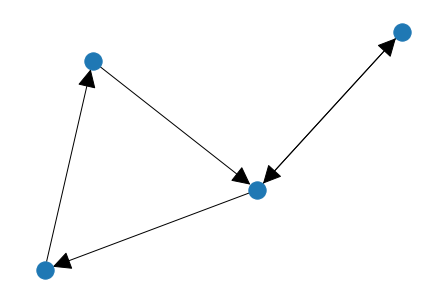

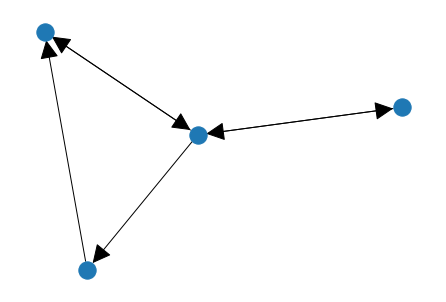

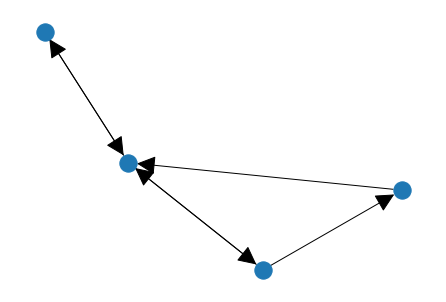

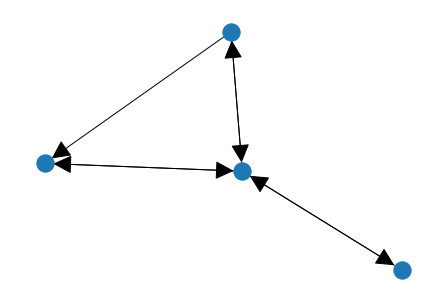

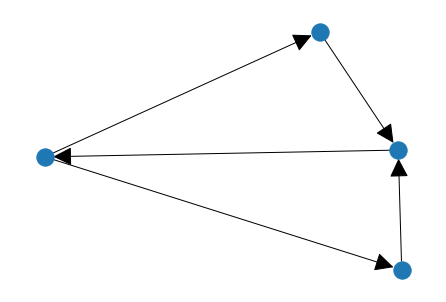

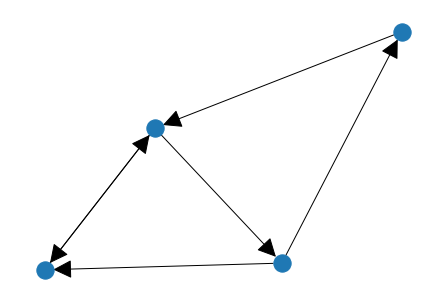

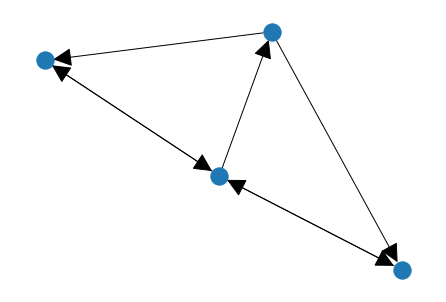

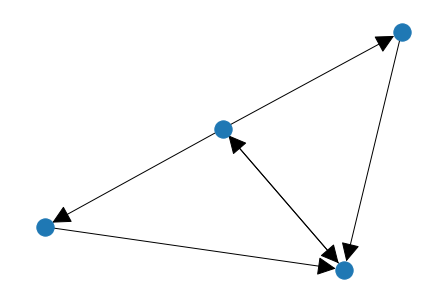

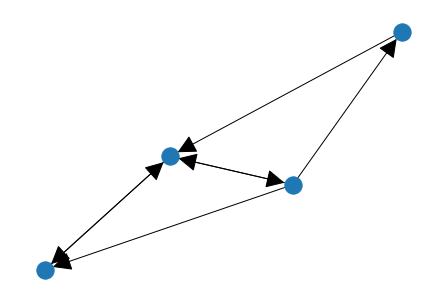

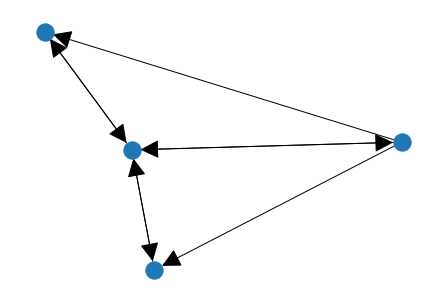

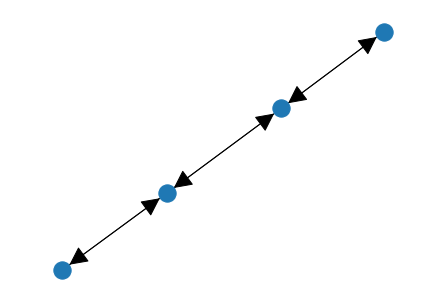

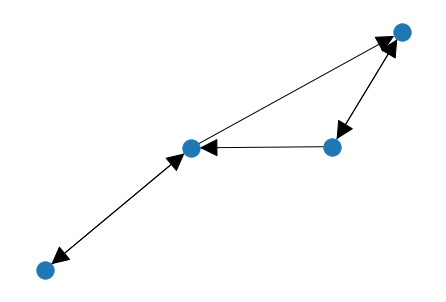

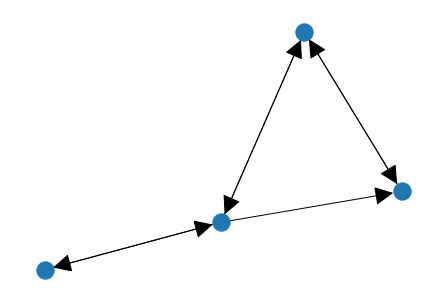

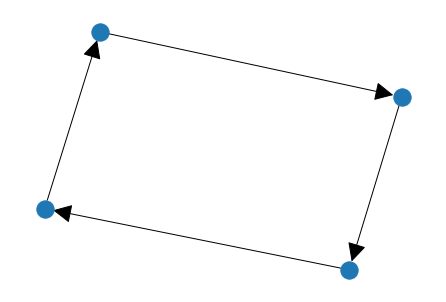

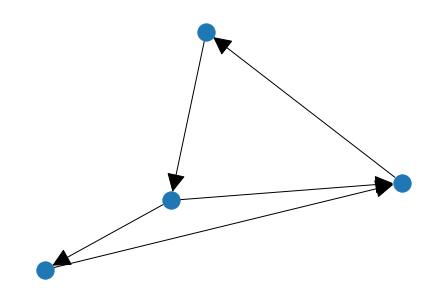

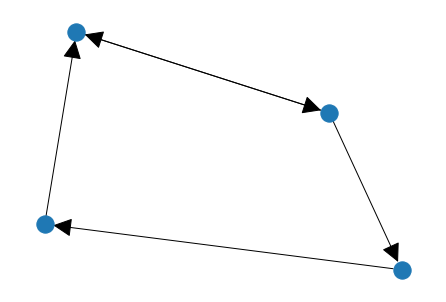

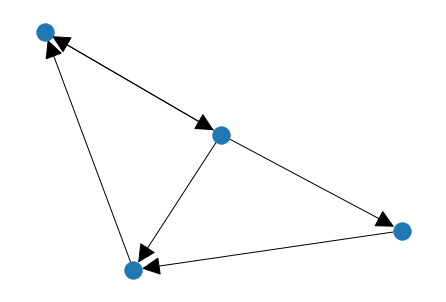

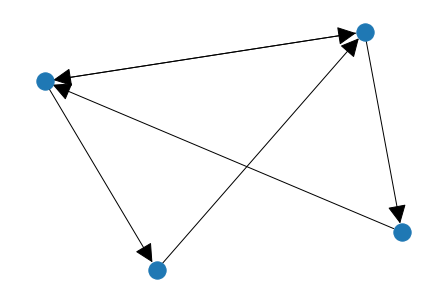

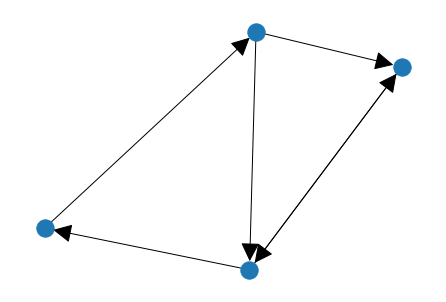

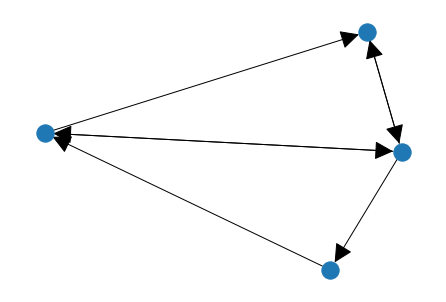

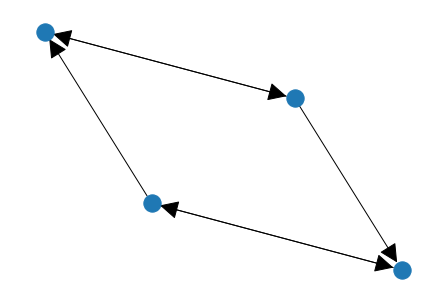

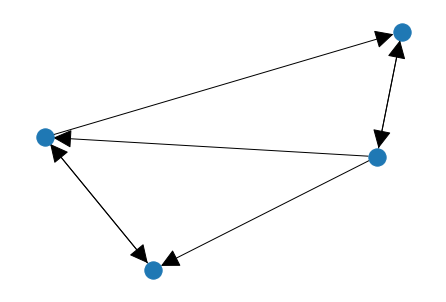

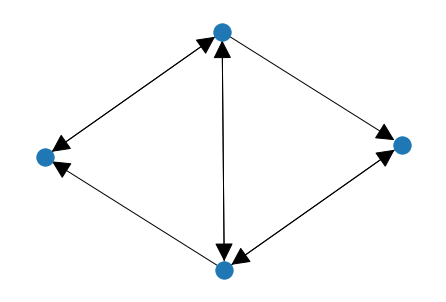

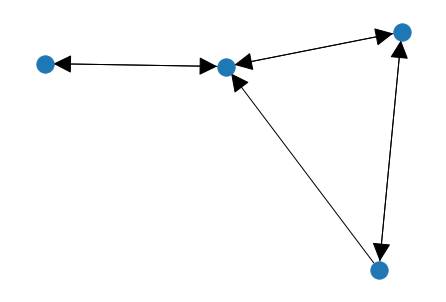

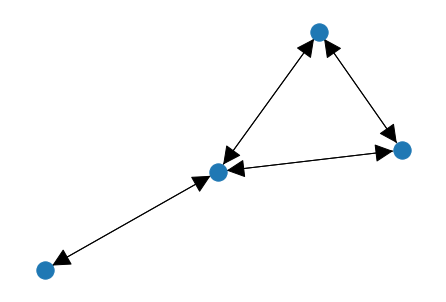

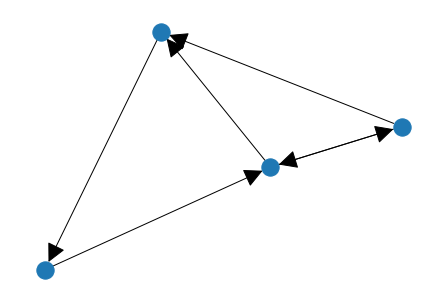

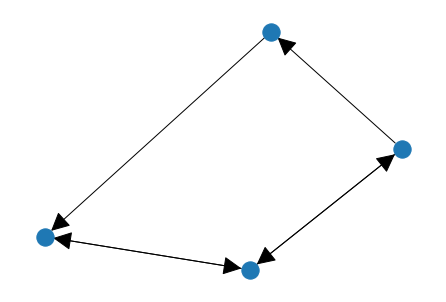

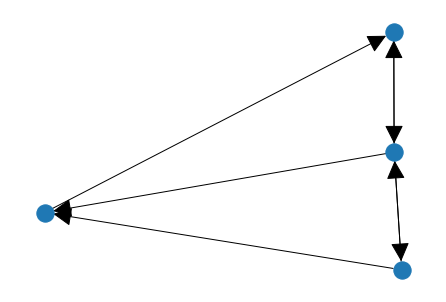

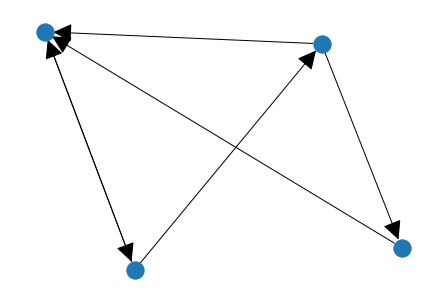

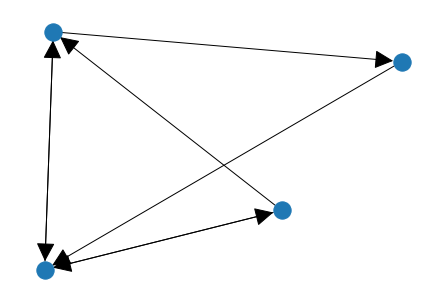

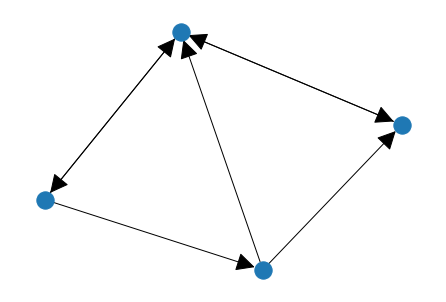

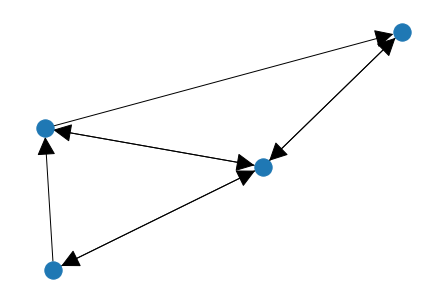

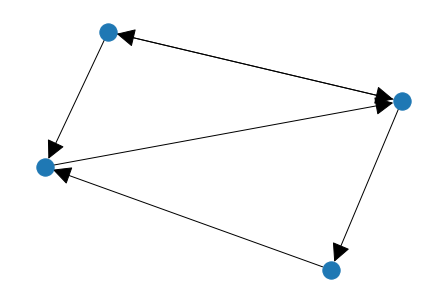

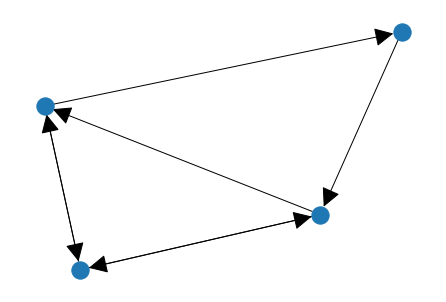

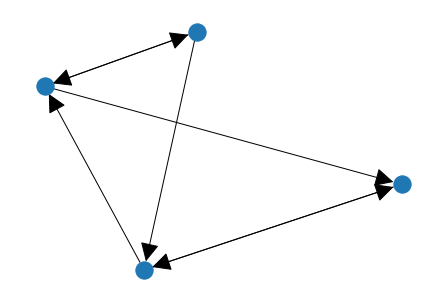

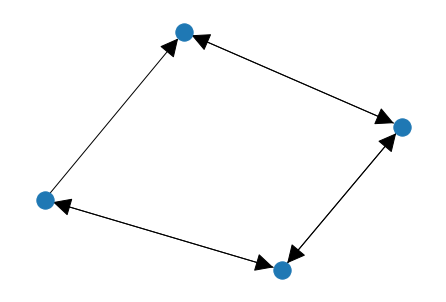

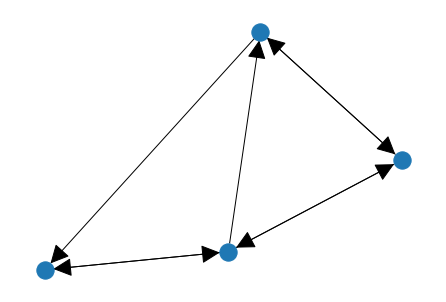

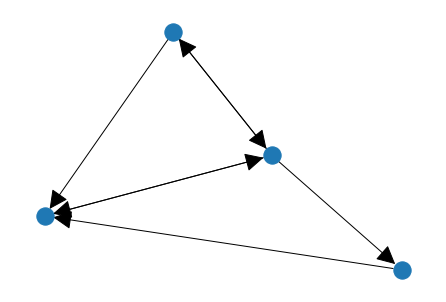

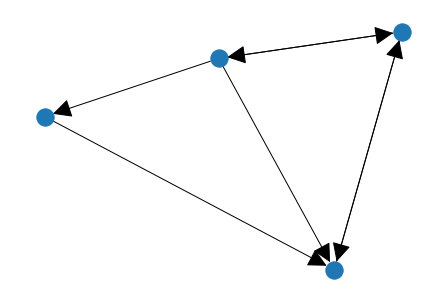

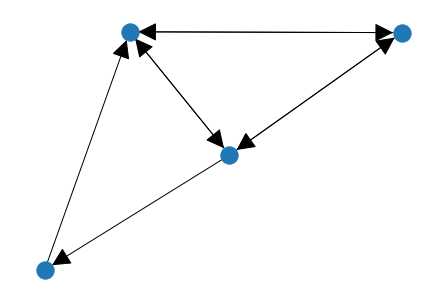

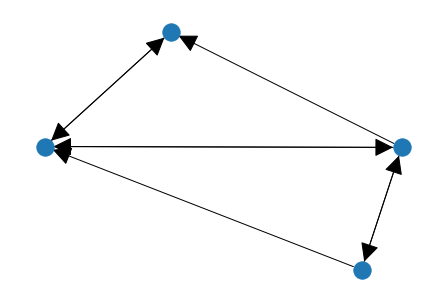

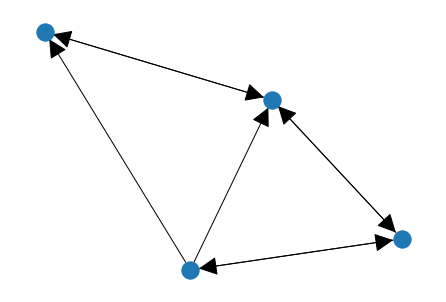

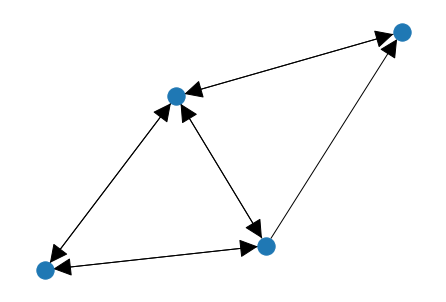

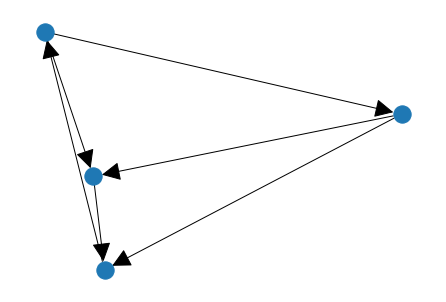

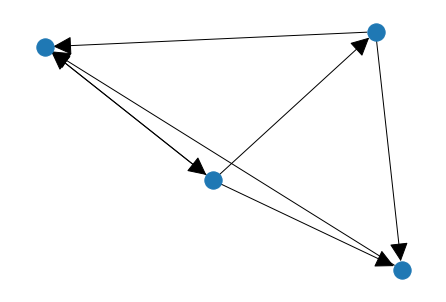

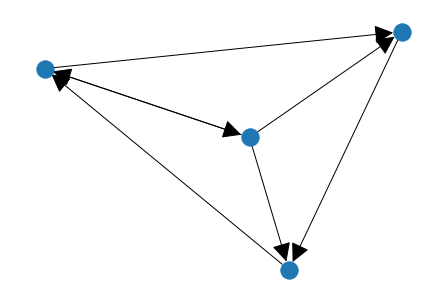

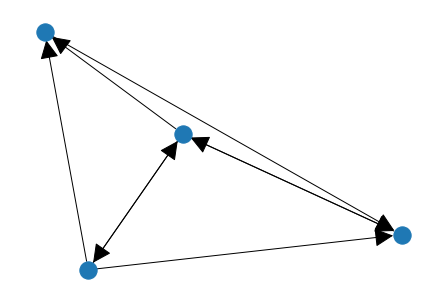

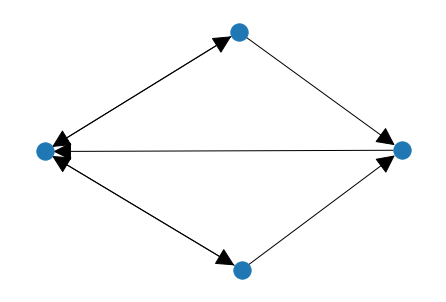

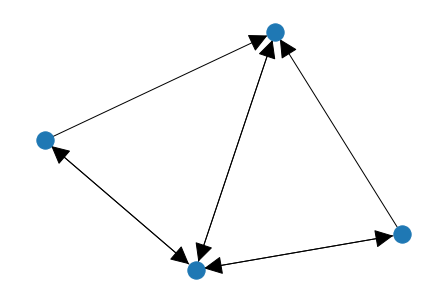

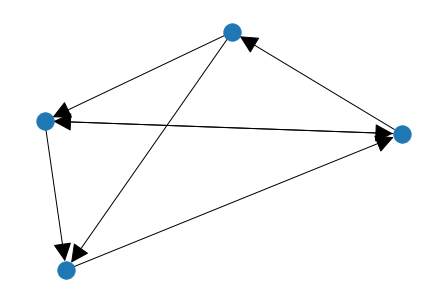

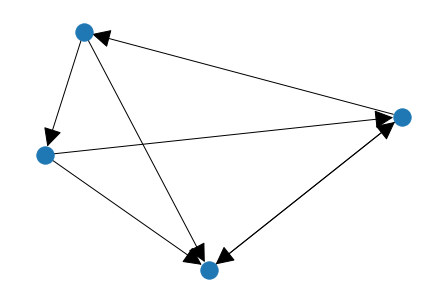

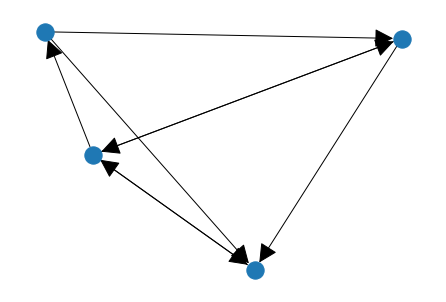

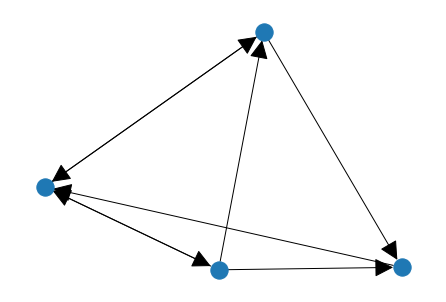

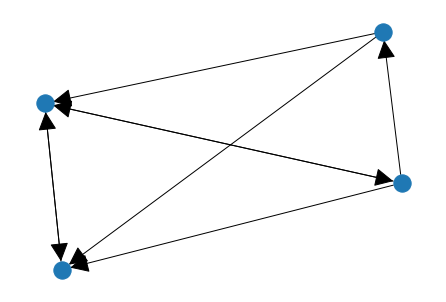

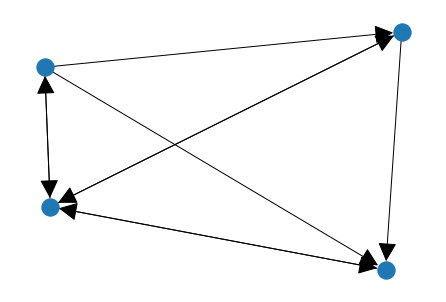

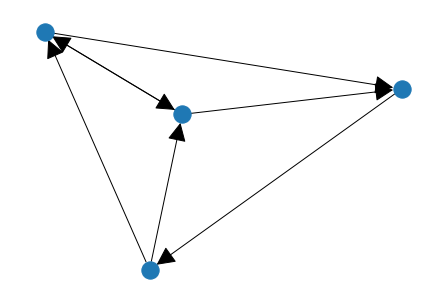

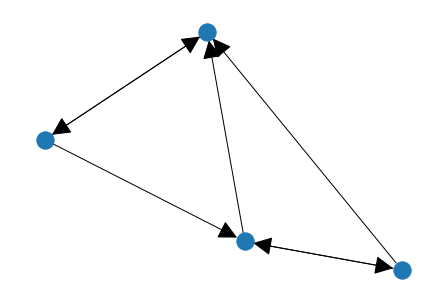

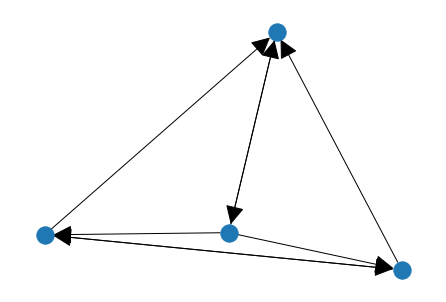

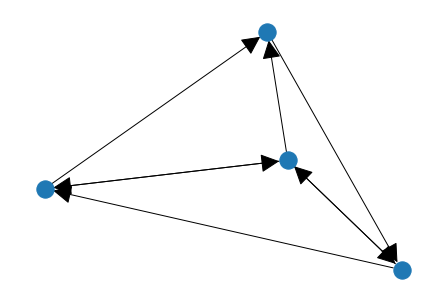

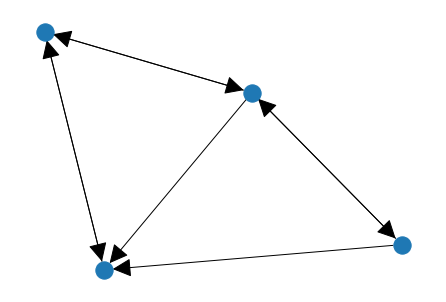

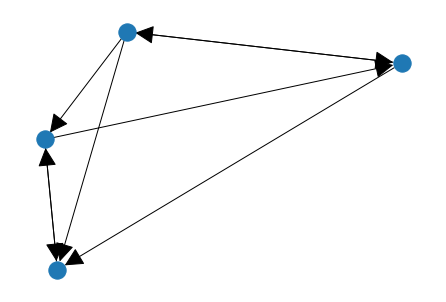

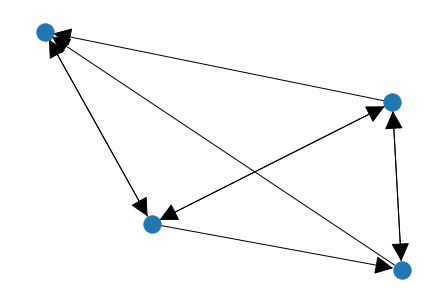

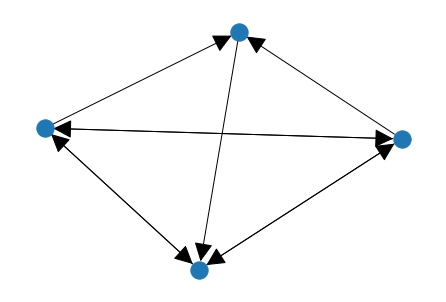

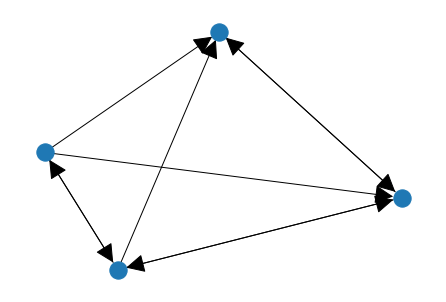

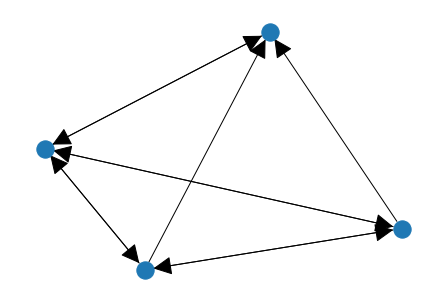

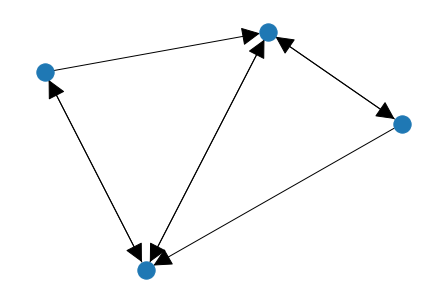

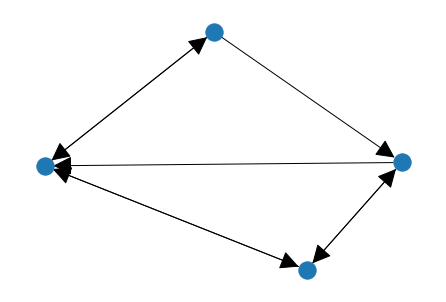

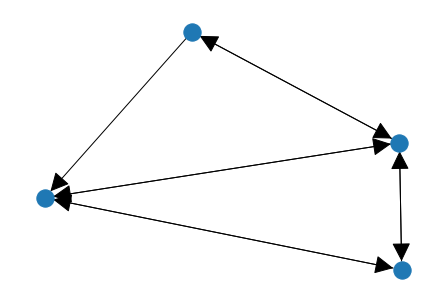

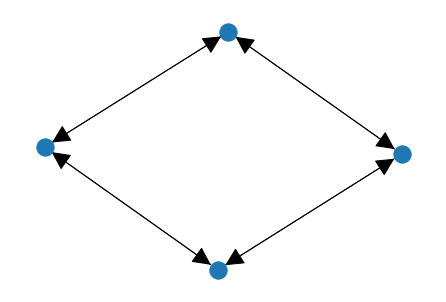

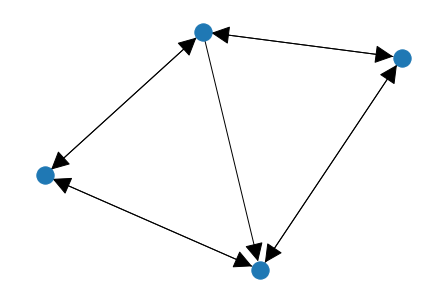

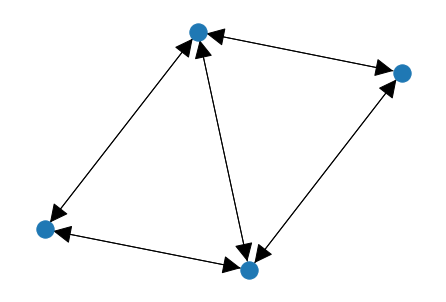

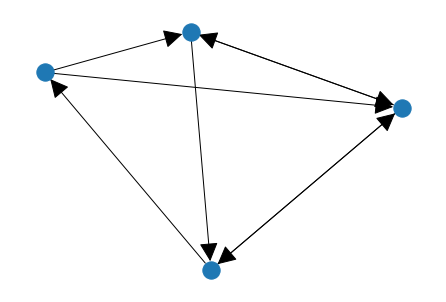

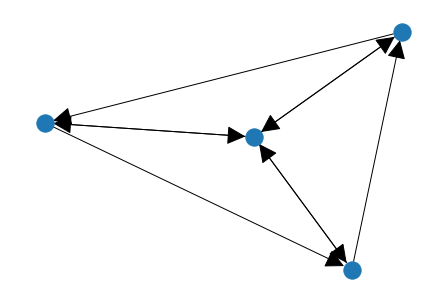

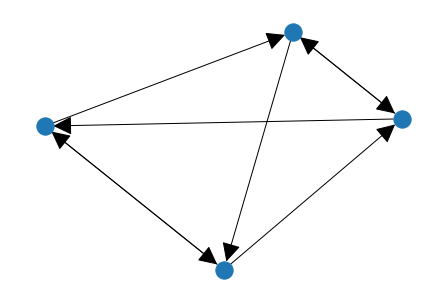

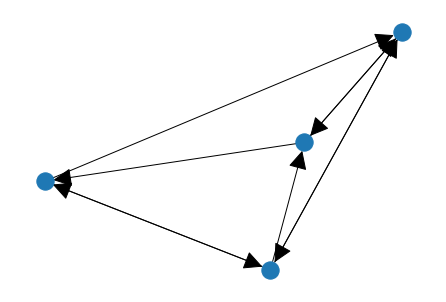

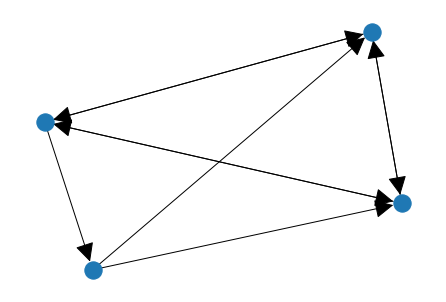

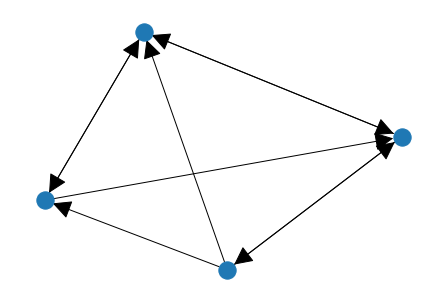

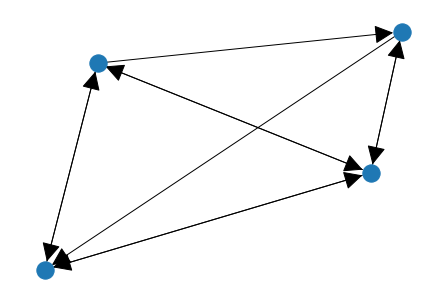

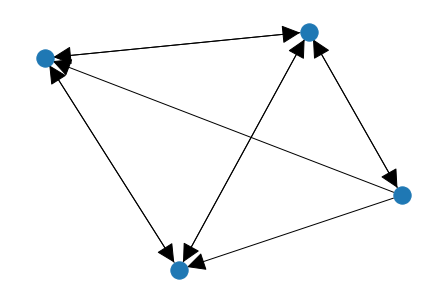

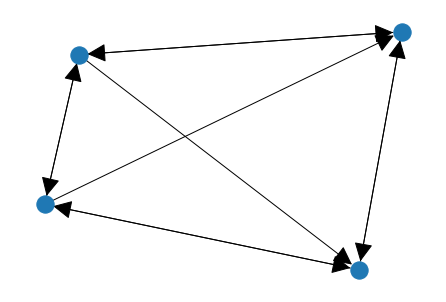

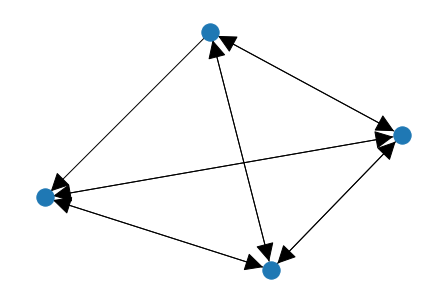

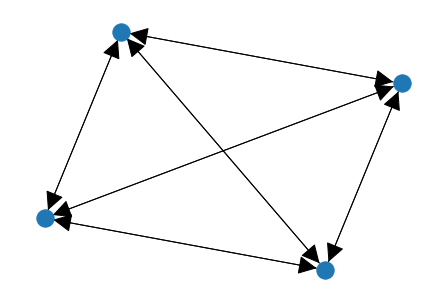

In [5]:
for n in range(2,5):
    count = 0
    collection = nice_graphs_naive(n)
    for A in collection:
        count += 1
        DG = nx.DiGraph(A)
        nx.draw(DG,arrowsize=40)
        plt.show()

In [6]:
def binary_combinations(l):
    for i in range(2**l,2**(l+1)):
        yield np.array([b for b in bin(i)[3:]],dtype=np.int8).tolist()

def all_triangles(n):
    for combo in binary_combinations((n*(n-1))//2):
        if np.sum(combo) == 0:
            continue
        triangle = np.zeros((n,n),dtype=np.int8)
        for d in range(1,n): # diagonal index
            l = n-d # how many entries on that diagonal
            diag = [combo.pop() for i in range(l)]
            triangle += np.diag(diag,d)
        yield triangle
        
def all_irreducible_matrices(n):
    for upper in all_triangles(n):
        for lower in all_triangles(n):
            A = upper + lower.T
            if np.sum(A) >= n:
                yield A
                
def isomorphic_fast(GA,collection):
    for GB in collection:
        if nx.algorithms.is_isomorphic(GA,GB):
            return True
    return False

def nice_graphs_fast(n): # able to get up to n=4
    """Returns all cyclic matrices of size n, 
    corresponding to graphs which have:
    - no unobserved confounding
    - strictly cyclic (no acylic graphs are returned)
    - strongly connected (encompasses previous condition)
    - no self loops
    - no isomorphic repeats
    """
    collection = []
    for upper in all_triangles(n):
        for lower in all_triangles(n):
            A = upper + lower.T # no self-loops by construction
            if np.sum(A) >= n: # not obviously acyclic
                # check if A is irreducible
                DG = nx.DiGraph(A)
                if nx.algorithms.components.is_strongly_connected(DG):
                    if not isomorphic_fast(DG,collection):
                        collection.append(DG)
    return collection

In [7]:
for n in range(2,5):
    count = 0
    for A in nice_graphs_naive(n):
        count += 1
    print("n={}, count={}".format(n,count))

n=2, count=1
n=3, count=5
n=4, count=83


In [19]:
for n in range(2,6):
    count = 0
    for A in nice_graphs_fast(n):
        count += 1
    print("n={}, count={}".format(n,count))

n=2, count=1
n=3, count=5
n=4, count=83


KeyboardInterrupt: 

In [15]:
# speed comparison
n = 4

start = time.time()
collection = nice_graphs_naive(n)
end = time.time()
print("n={}, naive: {}".format(n,end-start))

start = time.time()
collection = nice_graphs_fast(n)
end = time.time()
print("n={}, fast: {}".format(n,end-start))

n=4, naive: 4.658428907394409
n=4, fast: 1.7500133514404297


In [18]:
n = 4
%prun nice_graphs_fast(n)

In [20]:
collection = nice_graphs_fast(5)

In [21]:
print(len(collection))

5048


In [22]:
import pickle

In [24]:
x =5
pickle.dump(x,"test.pickle")

TypeError: file must have a 'write' attribute

In [25]:
outfile = open("nice_DiGraphs_5.pickle",'wb')
pickle.dump(collection,outfile)
outfile.close()